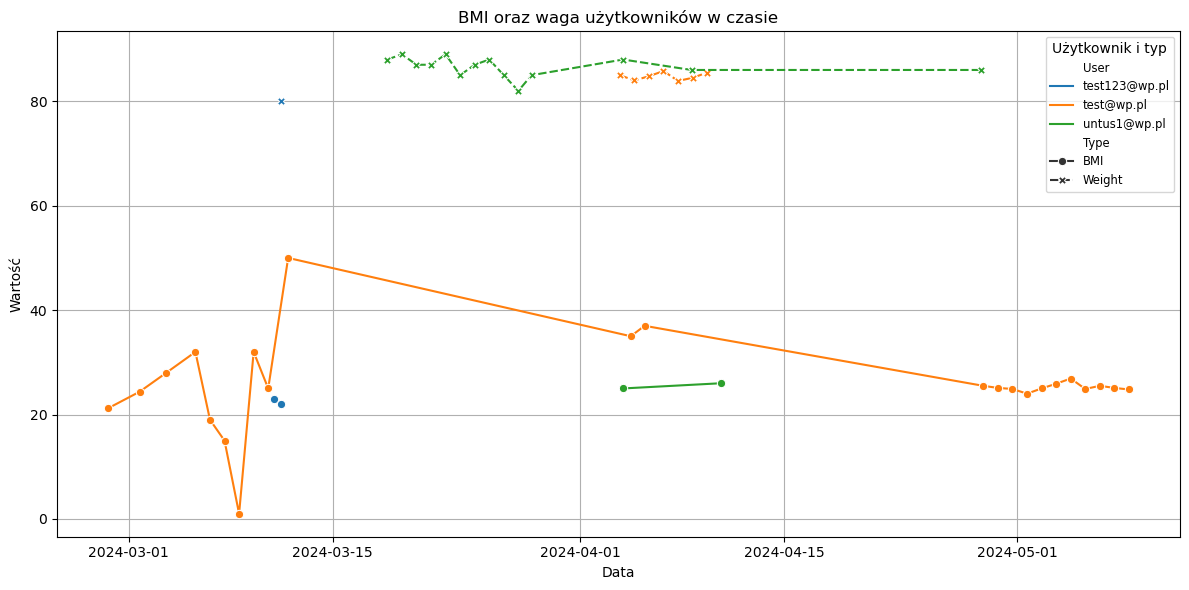

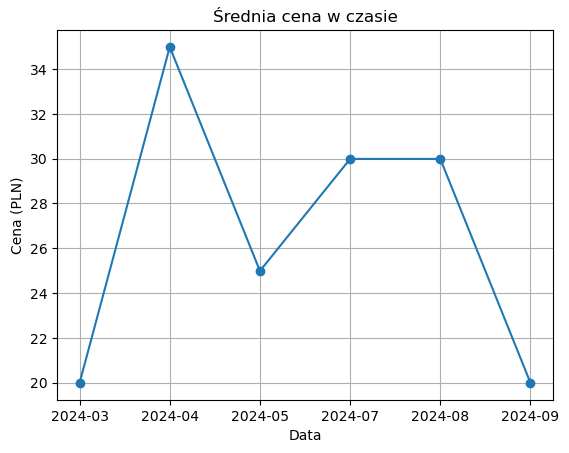

               Średnie_BMI  Minimalne_BMI  Maksymalne_BMI
username                                                 
test123@wp.pl    22.500000           22.0            23.0
test@wp.pl       25.964348            1.0            50.0
untus1@wp.pl     25.500000           25.0            26.0


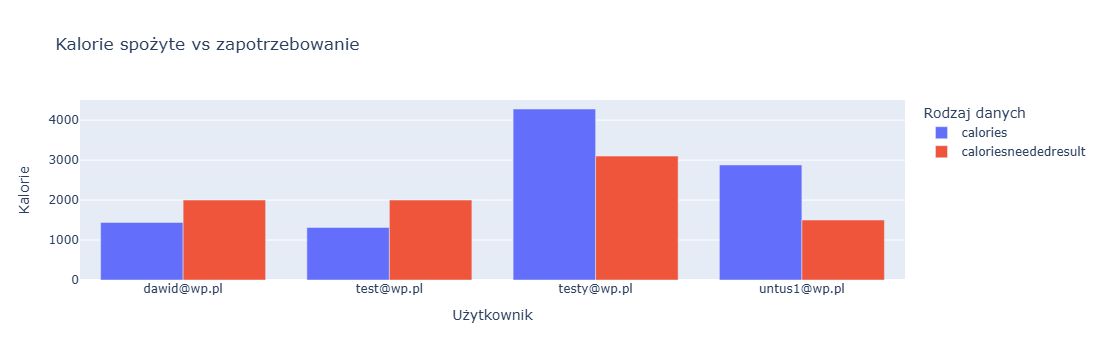

C:\Users\d_gar\AppData\Local\Temp\ipykernel_3228\2303860186.py:135: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




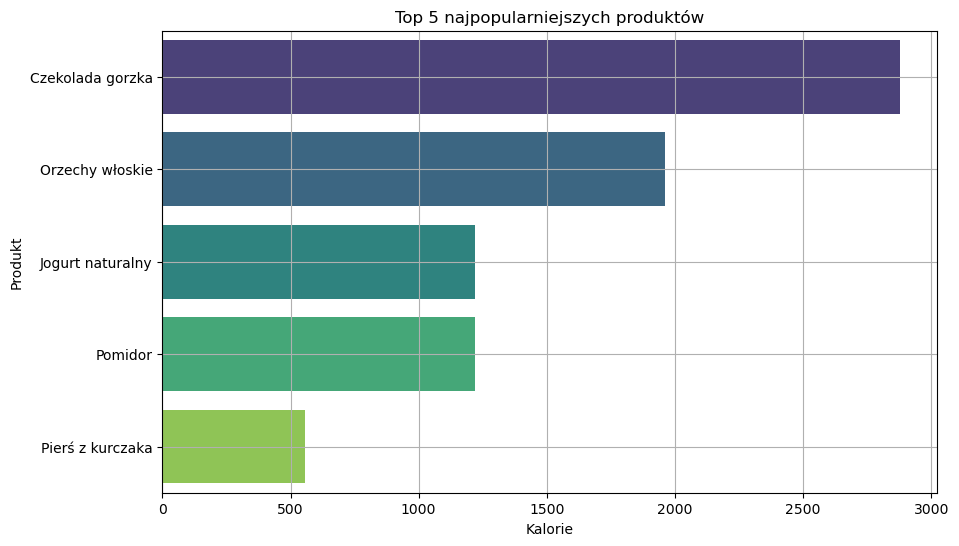

       username        Date  calories  caloriesneededresult         ---------
0   dawid@wp.pl  2024-03-25    1440.0                2000.0  Nie przekroczono
1    test@wp.pl  2024-03-25    1315.1                2000.0  Nie przekroczono
2   testy@wp.pl  2024-03-25    4279.0                3100.0      Przekroczono
3  untus1@wp.pl  2024-03-25    2878.5                1500.0      Przekroczono


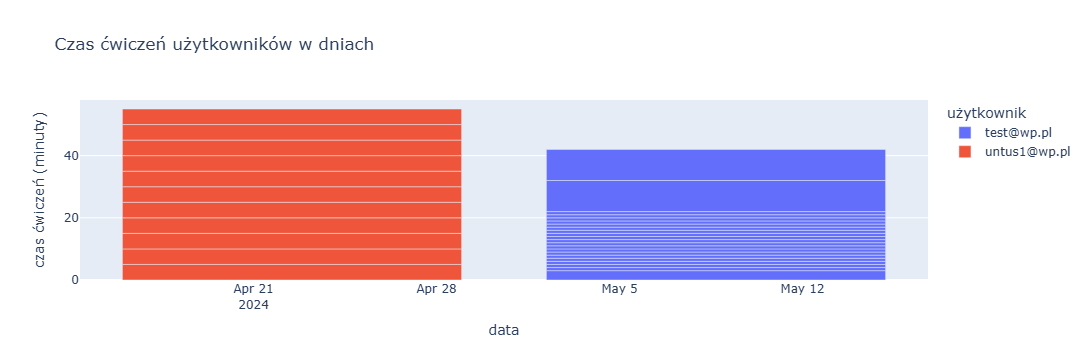

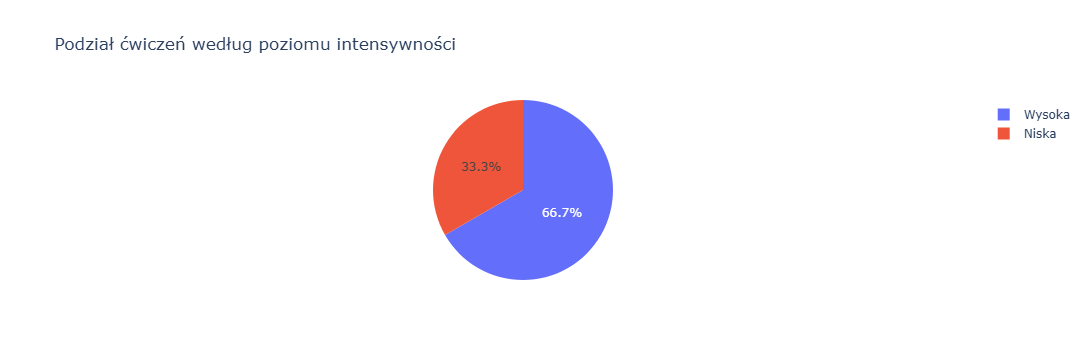

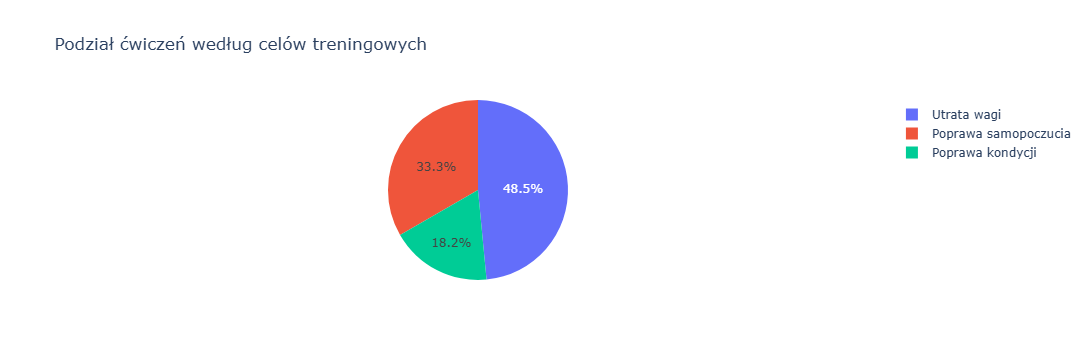

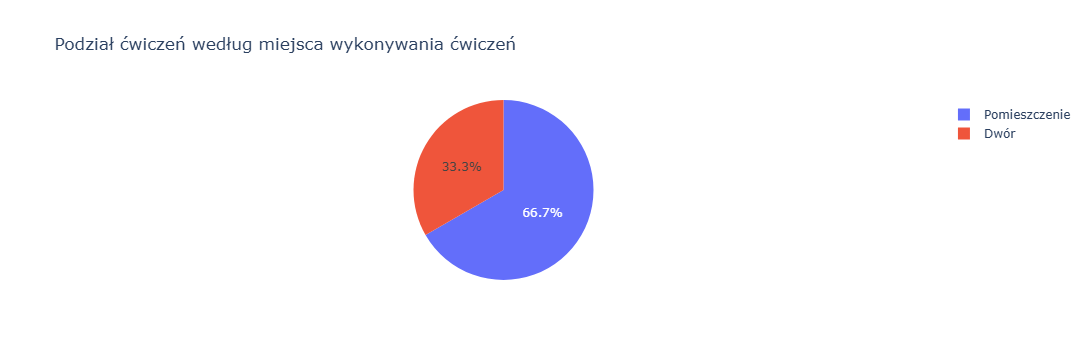

                exercisename  count
0   Joga - Pozycja wojownika     11
1             Agility Drills      2
2              Flutter Kicks      2
3        Lateral Jump Squats      2
4          Mountain Climbers      2
5                Power Skips      2
6              Speed Skaters      2
7                Squat Jumps      2
8        Wyskoki z przysiadu      2
9                   Air Bike      1
10                Butt Kicks      1
11      Podskoki na skrzynię      1
12            Russian Twists      1
13                  Skakanka      1
14                   Skaters      1


In [5]:
    # Zadanie4
    #"- Autor: Dawid Garncarek\n",
    #"- Grupa: 3\n",
    #"- Prowadzący: Bogdan Ruszczak\n",
    #"- Opis: \n",
    #"  1. Analiza danych cen, wagi i BMI\n",
    #"  2. Analiza kalorii użytkowników i produktów spożywczych\n",
    #"  3. Analiza planu ćwiczeniowego"

    !pip install sqlalchemy cx_Oracle pandas
    !pip install seaborn
    !pip install matplotlib
    !pip install plotly
    import os
    from sqlalchemy import create_engine
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import plotly.express as px
    from IPython.display import display
    import cx_Oracle


    username = 'S101095'
    password = 'S101095'
    host = '217.173.198.135'
    port = '1521'
    service_name = 'tpdb'

    dsn = f'{username}:{password}@{host}:{port}/?service_name={service_name}'
 
    engine = create_engine(f'oracle+cx_oracle://{username}:{password}@{host}:{port}/?service_name={service_name}')
    connection = engine.connect()

    # Analiza 1
    # Pobranie danych
    query_price = """SELECT pricedate, price, username FROM price"""
    query_weight = """SELECT weightdate, userweight, username FROM weight"""
    query_bmi = """SELECT calculationdate, resultbmi, username FROM bmiresult"""

    df_price = pd.read_sql(query_price, connection)
    df_weight = pd.read_sql(query_weight, connection)
    df_bmi = pd.read_sql(query_bmi, connection)

    # Tworzenie DataFrame
    df_analysis1 = pd.merge(df_weight, df_bmi, on="username", how="inner")
    df_analysis2 = pd.merge(df_analysis1, df_bmi, on="username", how="inner")
    df_analysis1 = pd.merge(df_analysis1, df_weight, on="username", how="inner")

    # Wizualizacja 1: Zależność BMI od wagi
    df_weight['weightdate'] = pd.to_datetime(df_weight['weightdate'])
    df_bmi['calculationdate'] = pd.to_datetime(df_bmi['calculationdate'])

    # Tworzenie DataFrame z połączonymi datami i wartościam
    df_weight.rename(columns={"weightdate": "Date", "userweight": "Value", "username": "User"}, inplace=True)
    df_weight["Type"] = "Weight"
    df_bmi.rename(columns={"calculationdate": "Date", "resultbmi": "Value", "username": "User"}, inplace=True)
    df_bmi["Type"] = "BMI"
    df_combined = pd.concat([df_weight, df_bmi], ignore_index=True)

    # Sortowanie danych dla poprawnej wizualizacji
    df_combined.sort_values(by=["User", "Date"], inplace=True)

    # Formatowanie wykresu
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_combined, x="Date", y="Value", hue="User", style="Type", markers=True, dashes=True)
    plt.title("BMI oraz waga użytkowników w czasie")
    plt.xlabel("Data")
    plt.ylabel("Wartość")
    plt.legend(loc="best", fontsize="small", title="Użytkownik i typ")
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Wizualizacja 2: Średnia cena w czasie
    df_price['pricedate'] = pd.to_datetime(df_price['pricedate'])
    df_avg_price = df_price.groupby(df_price['pricedate'].dt.to_period("M")).mean(numeric_only=True).reset_index()
    plt.plot(df_avg_price['pricedate'].astype(str), df_avg_price['price'], marker='o')
    plt.title("Średnia cena w czasie")
    plt.xlabel("Data")
    plt.ylabel("Cena (PLN)")
    plt.grid()
    plt.show()

    # Grupowanie
    grouped_bmi = df_analysis1.groupby("username").agg({
    "resultbmi": ["mean", "min", "max"]})
    grouped_bmi.columns = ["Średnie_BMI", "Minimalne_BMI", "Maksymalne_BMI"]
    print(grouped_bmi)

    # Analiza 2

    # Pobranie danych
    query_calories_needed = """SELECT newcaloriesdate, caloriesneededresult, username FROM usercaloriesneeded"""
    query_calories_result_and_product_name = """SELECT r.newcaloriesdate, r.calories, r.productid, r.username, f.productname, f.calories_100g 
    FROM usercaloriesresult r JOIN foodproducts f ON r.productid = f.id"""

    df_calories_needed = pd.read_sql(query_calories_needed, connection)
    df_calories_result_and_product_name = pd.read_sql(query_calories_result_and_product_name, connection)

    # Tworzenie DataFrame
    df_analysis2 = pd.merge(df_calories_result_and_product_name, df_calories_needed, on="username", how="inner")

    # Grupowanie zapotrzebowania kalorycznego (jedna wartość na użytkownika)
    df_calories_needed_unique = df_calories_needed.groupby("username", as_index=False).agg({"caloriesneededresult": "mean"  })

    # Grupowanie spożytych kalorii (suma dla każdego użytkownika)
    df_calories_sum = df_calories_result_and_product_name.groupby("username", as_index=False).agg({"calories": "sum" })

    # Łączenie zredukowanych danych
    df_analysis2_fixed = pd.merge(df_calories_sum, df_calories_needed_unique, on="username", how="inner")

    # Tworzenie wykresu
    fig1 = px.bar(
        df_analysis2_fixed,
        x="username",
        y=["calories", "caloriesneededresult"],
        title="Kalorie spożyte vs zapotrzebowanie",
        labels={"value": "Kalorie", "username": "Użytkownik"},
        barmode="group"
    )

    fig1.update_layout(
        xaxis_title="Użytkownik",
        yaxis_title="Kalorie",
        legend_title="Rodzaj danych"
    )

    fig1.show()


    # Wizualizacja 2: Najpopularniejsze produkty
    popular_products = df_analysis2.groupby("productname")["calories"].sum().nlargest(5).reset_index()
    plt.figure(figsize=(10, 6))
    sns.barplot(data=popular_products, x="calories", y="productname", palette="viridis")
    plt.title("Top 5 najpopularniejszych produktów")
    plt.xlabel("Kalorie")
    plt.ylabel("Produkt")
    plt.grid()
    plt.show()

    # Grupowanie
    # Konwersja daty w tabeli kalorii spożytych
    df_calories_result_and_product_name["newcaloriesdate"] = pd.to_datetime(
        df_calories_result_and_product_name["newcaloriesdate"], errors="coerce")

    # Grupowanie kalorii spożytych po użytkowniku i dacie
    daily_calories = df_calories_result_and_product_name.groupby(
        ["username", "newcaloriesdate"], as_index=False).agg({"calories": "sum"})

    # Grupowanie zapotrzebowania kalorycznego (średnie zapotrzebowanie na użytkownika)
    df_calories_needed_unique = df_calories_needed.groupby("username", as_index=False).agg({"caloriesneededresult": "mean"})

    # Łączenie danych: dzienne spożycie kalorii i zapotrzebowanie
    df_analysis_grouped = pd.merge(daily_calories, df_calories_needed_unique, on="username", how="inner")

    # Wyodrębnienie daty bez czasu
    df_analysis_grouped["Date"] = df_analysis_grouped["newcaloriesdate"].dt.date

    # Grupowanie po użytkowniku i dacie
    daily_summary = df_analysis_grouped.groupby(["username", "Date"], as_index=False).agg({
        "calories": "sum",                 
        "caloriesneededresult": "mean",})

    # Dodanie kolumny 'Przekroczono'
    daily_summary["---------"] = daily_summary.apply(lambda row: "Przekroczono" if row["calories"] > row["caloriesneededresult"] else "Nie przekroczono",axis=1)

    # Wyświetlenie wyników
    print(daily_summary)

    # Analiza 3
    # Pobranie danych
    query_user_exercise_sets = """
    SELECT u.username, u.dateassigned, u.trainingday, e.exercisename, e.intensitylevel, e.durationminutes, e.goals, e.exerciselocation
    FROM userexercisesets u
    JOIN exercises e ON u.exercisesetid = e.id
    JOIN aspnetusers a ON u.username = a.username
    """

    df_exercises = pd.read_sql(query_user_exercise_sets, connection)

    # Konwersja kolumny dateassigned na typ datetime
    df_exercises['dateassigned'] = pd.to_datetime(df_exercises['dateassigned'], errors='coerce')


    # Wizualizacja 1: Sumaryczny czas ćwiczeń w dniach
    fig1 = px.bar(
        df_exercises,
        x='dateassigned',
        y='durationminutes',
        color='username',
        title="Czas ćwiczeń użytkowników w dniach",
        labels={"dateassigned": "data", "durationminutes": "czas ćwiczeń (minuty)", "username": "użytkownik"}
    )
    fig1.show()

    # Wizualizacja 2: Liczba dni treningowych i kategorie intensywności
    intensity_distribution = df_exercises.groupby('intensitylevel', as_index=False).size()

    fig2 = px.pie(
        intensity_distribution,
        names='intensitylevel',
        values='size',
        title="Podział ćwiczeń według poziomu intensywności",
        labels={"intensitylevel": "poziom intensywności"}
    )
    fig2.show()

    # Wizualizacja 3: Podział ćwiczeń według celów 
    goals_distribution = df_exercises.groupby('goals', as_index=False).size()

    fig3 = px.pie(
        goals_distribution,
        names='goals',
        values='size',
        title="Podział ćwiczeń według celów treningowych",
        labels={"goals": "cel treningowy"}
    )
    fig3.show()

    # Wizualizacja 4: Podział ćwiczeń według miejsca ćwiczeń
    goals_distribution = df_exercises.groupby('exerciselocation', as_index=False).size()

    fig3 = px.pie(
        goals_distribution,
        names='exerciselocation',
        values='size',
        title="Podział ćwiczeń według miejsca wykonywania ćwiczeń",
        labels={"exerciselocation": "miejsce treningu"}
    )
    fig3.show()

    # Grupowanie danych na najpopularniejsze ćwiczenia
    popular_exercises = df_exercises.groupby('exercisename', as_index=False).size()
    popular_exercises.rename(columns={'size': 'count'}, inplace=True)
    popular_exercises = popular_exercises.sort_values(by='count', ascending=False)
    popular_exercises.reset_index(drop=True, inplace=True)
    print(popular_exercises)
